In [1]:
#| hide
import sys, os
sys.path.append(os.path.abspath('../__pypackages__/3.9/lib/'))
print(sys.path)

['/afs/crc.nd.edu/user/n/nclark3/Private/git/nbdev-framework-example/nbs', '/afs/crc.nd.edu/user/n/nclark3/Private/git/nbdev-framework-example/envs/lib/python39.zip', '/afs/crc.nd.edu/user/n/nclark3/Private/git/nbdev-framework-example/envs/lib/python3.9', '/afs/crc.nd.edu/user/n/nclark3/Private/git/nbdev-framework-example/envs/lib/python3.9/lib-dynload', '', '/afs/crc.nd.edu/user/n/nclark3/Private/git/nbdev-framework-example/envs/lib/python3.9/site-packages', '/afs/crc.nd.edu/user/n/nclark3/Private/git/nbdev-framework-example/__pypackages__/3.9/lib']


In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
from datasets import Dataset,DatasetDict,load_dataset
import torch

/afs/crc.nd.edu/user/n/nclark3/Private/git/nbdev-framework-example/__pypackages__/3.9/lib/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Evaluating Model

In [3]:
cleaned_data = "../data/processed-data/nn"

Define kfold for evaluation

In [4]:
kfold = 1

Load Evaluation Dataset

In [5]:
val_dataset = pd.read_csv(f'{cleaned_data}/val/FAA-{kfold}.csv',header=0)

In [6]:
#| hide
assert val_dataset.shape == (440, 2)

(440, 2)

Import fine-tuned model

In [7]:
model_path = '../output/model'
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [8]:
text = val_dataset.text

In [9]:
predictions = []
actual_predictions = []

for row in text:
    inputs = tokenizer(row, return_tensors="pt")
    
    with torch.no_grad():
        logits = model(**inputs).logits
    
    predictions.append(logits)
    actual_predictions.append(logits.argmax().item())

## Visualizations

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

### Prediction Heat Maps

Count correct predictions and add to heat map

In [11]:
correct = 0
heat_map = np.zeros((7,7), dtype=float)

for index, label in enumerate(val_dataset.label):
    if label == actual_predictions[index]:
        correct += 1
    
    heat_map[6 - actual_predictions[index]][label] = heat_map[ 6 - actual_predictions[index]][label] + 1

print("Correct based on my actual predictions: ", correct/len(actual_predictions))

Correct based on my actual predictions:  0.09772727272727273


Normalize heat map

In [12]:
for i, category in enumerate(heat_map):
    total = 0
    
    for val in category:
        total = total + val
        
    for j, val in enumerate(category):
        heat_map[i][j] = val / total

/tmp/ipykernel_3087904/3763083728.py:8: RuntimeWarning: invalid value encountered in double_scalars
  heat_map[i][j] = val / total


Plot heat map

<Axes: >

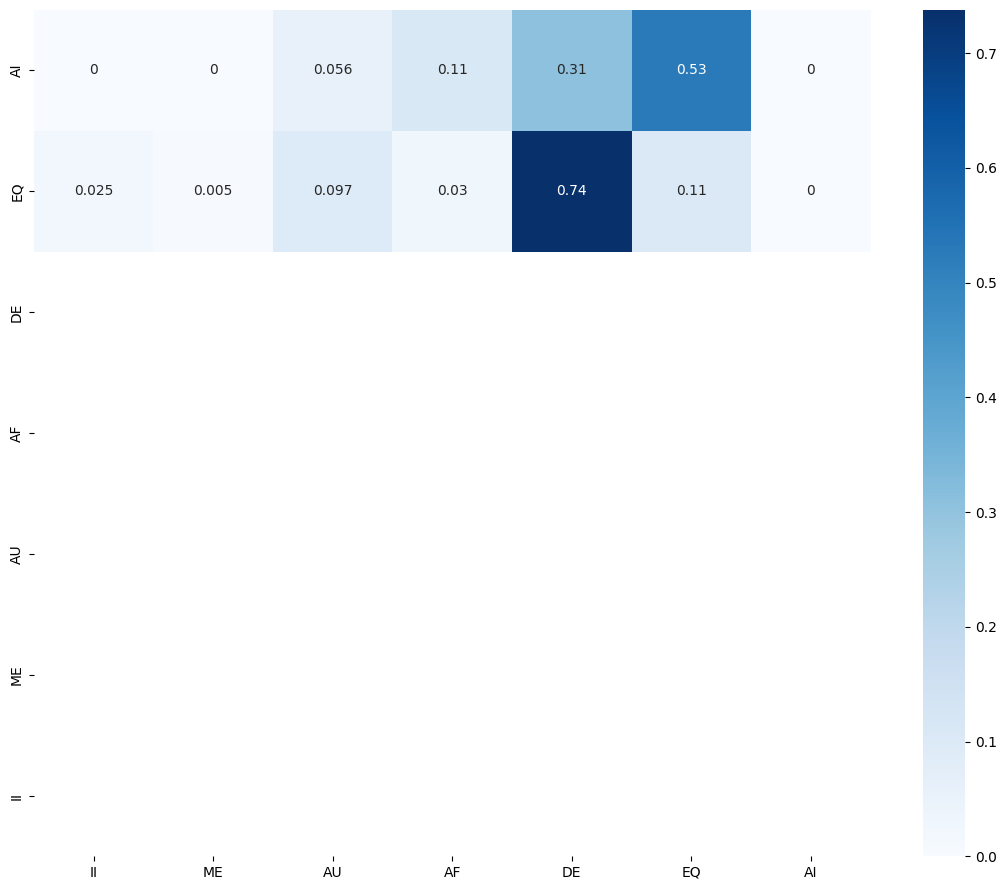

In [13]:
fig, ax = plt.subplots(figsize=(11,9))
fig.set_tight_layout(True)
# color map
labels = ['II','ME','AU','AF','DE','EQ','AI']
y_labels = ['AI','EQ','DE','AF','AU','ME','II']
sb.heatmap(heat_map,cmap="Blues",xticklabels=labels, yticklabels=y_labels, annot=True)

In [14]:
fig.savefig(f'../output/visualizations/heatmap-{kfold}.pdf')